# Augmented Neural ODEs in Tensorflow

The following code has been ported from the codebase of the authors of the ["Augmented Neural Ordinary Differential Equations"](https://arxiv.org/abs/1904.01681) paper.

The original codebase can be found here - https://github.com/EmilienDupont/augmented-neural-ode

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Note: All visualization code is obtained from the following 

### References
- https://github.com/EmilienDupont/augmented-neural-odes/blob/master/viz/plots.py

In [0]:
""" All visualization code obtained from https://github.com/EmilienDupont/augmented-neural-odes/blob/master/viz/plots.py """

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import Axes3D, proj3d


categorical_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

all_categorical_colors = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                          '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                          '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                          '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']

## Eager Execution Requirements
This codebase is built for Tensorflow 2.0 or Tensorflow 1.x with Eager Execution enabled

In [0]:
import tensorflow as tf
tf.enable_eager_execution()

## Install the Tensorflow Differential Equation library

This lib now has inbuilt support for not only ODE solvers but also ODENet models as well as Convolutional ODENet models.

In [4]:
!pip install --upgrade -q git+https://github.com/titu1994/tfdiffeq.git

In [0]:
from tfdiffeq import odeint
from tfdiffeq.models import ODENet

In [0]:
device = 'cpu:0'
np.random.seed(0)

# Input dimension is 2d so that we can visualize the data easily.
data_dim = 2
batchsize = 500

## Visualization utilities

As discussed above, these visualization utilities have been ported from the original ANODE codebase for use with Tensorflow models.

In [0]:
""" Obtained from https://github.com/EmilienDupont/augmented-neural-odes/blob/master/viz/plots.py """

def get_square_aspect_ratio(plt_axis):
    return np.diff(plt_axis.get_xlim())[0] / np.diff(plt_axis.get_ylim())[0]

def single_feature_plt(features, targets, save_fig=''):
    """Plots a feature map with points colored by their target value. Works for
    2 or 3 dimensions.
    Parameters
    ----------
    features : torch.Tensor
        Tensor of shape (num_points, 2) or (num_points, 3).
    targets : torch.Tensor
        Target points for ODE. Shape (num_points, 1). -1 corresponds to blue
        while +1 corresponds to red.
    save_fig : string
        If string is non empty, save figure to the path specified by save_fig.
    """
    alpha = 0.5
    color = ['red' if targets[i, 0] > 0.0 else 'blue' for i in range(len(targets))]
    num_dims = features.shape[1]

    if num_dims == 2:
        plt.scatter(features[:, 0].numpy(), features[:, 1].numpy(), c=color,
                    alpha=alpha, linewidths=0)
        plt.tick_params(axis='both', which='both', bottom=False, top=False,
                        labelbottom=False, right=False, left=False,
                        labelleft=False)
        ax = plt.gca()
    elif num_dims == 3:
        fig = plt.figure()
        ax = Axes3D(fig)
        ax.scatter(features[:, 0].numpy(), features[:, 1].numpy(),
                   features[:, 2].numpy(), c=color, alpha=alpha,
                   linewidths=0, s=80)
        ax.tick_params(axis='both', which='both', bottom=False, top=False,
                       labelbottom=False, right=False, left=False,
                       labelleft=False)

    ax.set_aspect(get_square_aspect_ratio(ax))

    if len(save_fig):
        fig.savefig(save_fig, format='png', dpi=200, bbox_inches='tight')
        plt.clf()
        plt.close()
    else:
        plt.show()

In [0]:
""" Obtained from https://github.com/EmilienDupont/augmented-neural-odes/blob/master/viz/plots.py """

def multi_feature_plt(features, targets, save_fig=''):
    """Plots multiple feature maps colored by their target value. Works for 2 or
    3 dimensions.
    Parameters
    ----------
    features : list of torch.Tensor
        Each list item has shape (num_points, 2) or (num_points, 3).
    targets : torch.Tensor
        Target points for ODE. Shape (num_points, 1). -1 corresponds to blue
        while +1 corresponds to red.
    save_fig : string
        If string is non empty, save figure to the path specified by save_fig.
    """
    alpha = 0.5
    color = ['red' if targets[i, 0] > 0.0 else 'blue' for i in range(len(targets))]
    num_dims = features[0].shape[1]

    if num_dims == 2:
        fig, axarr = plt.subplots(1, len(features), figsize=(20, 10))
        for i in range(len(features)):
            axarr[i].scatter(features[i][:, 0].numpy(), features[i][:, 1].numpy(),
                             c=color, alpha=alpha, linewidths=0)
            axarr[i].tick_params(axis='both', which='both', bottom=False,
                                 top=False, labelbottom=False, right=False,
                                 left=False, labelleft=False)
            axarr[i].set_aspect(get_square_aspect_ratio(axarr[i]))
    elif num_dims == 3:
        fig = plt.figure(figsize=(20, 10))
        for i in range(len(features)):
            ax = fig.add_subplot(1, len(features), i + 1, projection='3d')

            ax.scatter(features[i][:, 0].numpy(), features[i][:, 1].numpy(),
                       features[i][:, 2].numpy(), c=color, alpha=alpha,
                       linewidths=0, s=80)
            ax.tick_params(axis='both', which='both', bottom=False, top=False,
                           labelbottom=False, right=False, left=False,
                           labelleft=False)
            ax.set_aspect(get_square_aspect_ratio(ax))

    fig.subplots_adjust(wspace=0.01)

    if len(save_fig):
        fig.savefig(save_fig, format='png', dpi=200, bbox_inches='tight')
        plt.clf()
        plt.close()
    else:
        plt.show()

In [0]:
""" Obtained from https://github.com/EmilienDupont/augmented-neural-odes/blob/master/viz/plots.py """

class Arrow3D(FancyArrowPatch):
    """Class used to draw arrows on 3D plots. Taken from:
    https://stackoverflow.com/questions/22867620/putting-arrowheads-on-vectors-in-matplotlibs-3d-plot
    """
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)

def trajectory_plt(model, inputs, targets, timesteps, highlight_inputs=False,
                   include_arrow=False, save_fig=''):
    """Plots trajectory of input points when evolved through model. Works for 2
    and 3 dimensions.
    Parameters
    ----------
    model : anode.models.ODENet instance
    inputs : torch.Tensor
        Shape (num_points, num_dims) where num_dims = 1, 2 or 3 depending on
        augment_dim.
    targets : torch.Tensor
        Shape (num_points, 1).
    timesteps : int
        Number of timesteps to calculate for trajectories.
    highlight_inputs : bool
        If True highlights input points by drawing edge around points.
    include_arrow : bool
        If True adds an arrow to indicate direction of trajectory.
    save_fig : string
        If string is non empty, save figure to the path specified by save_fig.
    """
    alpha = 0.5
    color = ['red' if targets[i, 0] > 0.0 else 'blue' for i in range(len(targets))]
    # Calculate trajectories (timesteps, batch_size, input_dim)
    trajectories = model.odeblock.trajectory(inputs, timesteps)
    # Features are trajectories at the final time
    features = trajectories[-1]

    if model.augment_dim > 0:
        aug = tf.zeros([inputs.shape[0], model.odeblock.odefunc.augment_dim])
        inputs_aug = tf.concat([inputs, aug], 1)
    else:
        inputs_aug = inputs

    input_dim = inputs.shape[-1] + model.augment_dim

    if input_dim == 2:
        # Plot starting and ending points of trajectories
        input_linewidths = 2 if highlight_inputs else 0
        plt.scatter(inputs_aug[:, 0].numpy(), inputs_aug[:, 1].numpy(), c=color,
                    alpha=alpha, linewidths=input_linewidths, edgecolor='orange')
        plt.scatter(features[:, 0].numpy(), features[:, 1].numpy(), c=color,
                    alpha=alpha, linewidths=0)

        # For each point in batch, plot its trajectory
        for i in range(inputs_aug.shape[0]):
            # Plot trajectory
            trajectory = trajectories[:, i, :]
            x_traj = trajectory[:, 0].numpy()
            y_traj = trajectory[:, 1].numpy()
            plt.plot(x_traj, y_traj, c=color[i], alpha=alpha)
            # Optionally add arrow to indicate direction of flow
            if include_arrow:
                arrow_start = x_traj[-2], y_traj[-2]
                arrow_end = x_traj[-1], y_traj[-1]
                plt.arrow(arrow_start[0], arrow_start[1],
                          arrow_end[0] - arrow_start[0],
                          arrow_end[1] - arrow_start[1], shape='full', lw=0,
                          length_includes_head=True, head_width=0.15,
                          color=color[i], alpha=alpha)

        plt.tick_params(axis='both', which='both', bottom=False, top=False,
                        labelbottom=False, right=False, left=False,
                        labelleft=False)

        ax = plt.gca()
    elif input_dim == 3:
        # Create figure
        fig = plt.figure()
        ax = Axes3D(fig)

        # Plot starting and ending points of trajectories
        input_linewidths = 1 if highlight_inputs else 0
        ax.scatter(inputs_aug[:, 0].numpy(), inputs_aug[:, 1].numpy(),
                   inputs_aug[:, 2].numpy(), c=color, alpha=alpha,
                   linewidths=input_linewidths, edgecolor='orange')
        ax.scatter(features[:, 0].numpy(), features[:, 1].numpy(),
                   features[:, 2].numpy(), c=color, alpha=alpha, linewidths=0)

        # For each point in batch, plot its trajectory
        for i in range(inputs_aug.shape[0]):
            # Plot trajectory
            trajectory = trajectories[:, i, :]
            x_traj = trajectory[:, 0].numpy()
            y_traj = trajectory[:, 1].numpy()
            z_traj = trajectory[:, 2].numpy()
            ax.plot(x_traj, y_traj, z_traj, c=color[i], alpha=alpha)

            # Optionally add arrow
            if include_arrow:
                arrow_start = x_traj[-2], y_traj[-2], z_traj[-2]
                arrow_end = x_traj[-1], y_traj[-1], z_traj[-1]

                arrow = Arrow3D([arrow_start[0], arrow_end[0]],
                                [arrow_start[1], arrow_end[1]],
                                [arrow_start[2], arrow_end[2]],
                                mutation_scale=15,
                                lw=0, color=color[i], alpha=alpha)
                ax.add_artist(arrow)

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
    else:
        raise RuntimeError("Input dimension must be 2 or 3 but was {}".format(input_dim))

    ax.set_aspect(get_square_aspect_ratio(ax))

    if len(save_fig):
        plt.savefig(save_fig, format='png', dpi=400, bbox_inches='tight')
        plt.clf()
        plt.close()


## Dataset construction

We will use the Concentric Circles dataset from the ANODE codebase, found here.

Since Tensorflow's Dataset classes are not directly compatible with PyTorch Dataset mechanism, the dataset has been modified slightly to be compatible with Tensorflow's dataset API.

### References
 - https://github.com/EmilienDupont/augmented-neural-odes/blob/master/experiments/dataloaders.py

In [0]:
""" Ported from https://github.com/EmilienDupont/augmented-neural-odes/blob/master/experiments/dataloaders.py  """

def random_point_in_sphere(dim, min_radius, max_radius):
    """Returns a point sampled uniformly at random from a sphere if min_radius
    is 0. Else samples a point approximately uniformly on annulus.
    Parameters
    ----------
    dim : int
        Dimension of sphere
    min_radius : float
        Minimum distance of sampled point from origin.
    max_radius : float
        Maximum distance of sampled point from origin.
    """
    # Sample distance of point from origin
    unif = np.random.rand()
    distance = (max_radius - min_radius) * (unif ** (1. / dim)) + min_radius
    # Sample direction of point away from origin
    direction = tf.random.normal([dim])
    unit_direction = direction / tf.norm(direction)
    return distance * unit_direction


In [0]:
""" Ported from https://github.com/EmilienDupont/augmented-neural-odes/blob/master/experiments/dataloaders.py """

class ConcentricCircleDataset:
  
  """Dataset of concentric d-dimensional spheres. Points in the inner sphere
    are mapped to -1, while points in the outer sphere are mapped 1.
    Parameters
    ----------
    dim : int
        Dimension of spheres.
    inner_range : (float, float)
        Minimum and maximum radius of inner sphere. For example if inner_range
        is (1., 2.) then all points in inner sphere will lie a distance of
        between 1.0 and 2.0 from the origin.
    outer_range : (float, float)
        Minimum and maximum radius of outer sphere.
    num_points_inner : int
        Number of points in inner cluster
    num_points_outer : int
        Number of points in outer cluster
  """
  def __init__(self, dim, inner_range, outer_range, num_points_inner, num_points_outer):
    self.dim = dim
    self.inner_range = inner_range
    self.outer_range = outer_range
    self.num_points_inner = num_points_inner
    self.num_points_outer = num_points_outer

    self.data = []
    self.targets = []

    # Generate data for inner sphere
    for _ in range(self.num_points_inner):
        self.data.append(
            random_point_in_sphere(dim, inner_range[0], inner_range[1])
        )
        self.targets.append(tf.convert_to_tensor([-1.]))

    # Generate data for outer sphere
    for _ in range(self.num_points_outer):
        self.data.append(
            random_point_in_sphere(dim, outer_range[0], outer_range[1])
        )
        self.targets.append(tf.convert_to_tensor([1.]))
        
    self.data = tf.stack(self.data)
    self.targets = tf.stack(self.targets)
        
  def __getitem__(self, index):
        return self.data[index], self.targets[index]

  def __len__(self):
      return len(self.data)



## Construct the Tensorflow Dataset

In [0]:
circle_dataset = ConcentricCircleDataset(data_dim, inner_range=(0., .5), outer_range=(1., 1.5), num_points_inner=1000, num_points_outer=2000)

In [0]:
dataset = tf.data.Dataset.range(len(circle_dataset))
dataset = dataset.shuffle(len(circle_dataset) // 2)
dataset = dataset.map(lambda i: circle_dataset[i], num_parallel_calls=4)
dataset = dataset.batch(batchsize)

## Visualize the dataset 

Instructions for updating:
Colocations handled automatically by placer.


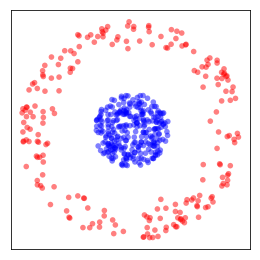

In [14]:
viz_x, viz_y = next(iter(dataset))
single_feature_plt(viz_x, viz_y)

## Classical Neural ODE

We first try training a classical neural ode on this dataset.

- We find that not only does it take more epochs, it cannot tolerate a very high learning rate as compared to ANODE.

- Note that both NODE and ANODE use Dopri5 solver with same tolerance (1e-3).

In [0]:
hidden_dim = 32
EPOCHS = 15

model = ODENet(hidden_dim, time_dependent=True, non_linearity='relu')
optimizer = tf.train.AdamOptimizer(0.01)

feature_history = []

# Get features at beginning of training
features, _ = model(viz_x, return_features=True)
feature_history.append(features)

In [16]:
with tf.device('cpu:0'):
  for epoch in range(EPOCHS):
    datagen = iter(dataset)
    
    avg_loss = tf.keras.metrics.Mean()
    
    for batch, (x, y) in enumerate(datagen):
      with tf.GradientTape() as tape:
        x = tf.cast(x, tf.float64)
        y_pred = model(x, training=True)
        
        loss = tf.losses.huber_loss(y, y_pred)
        
      grads = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))
      
      avg_loss(loss)
    
    print("Epoch %d: Loss = %0.6f" % (epoch + 1, avg_loss.result().numpy()))
    
    features, _ = model(viz_x, training=False, return_features=True)
    feature_history.append(features)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1: Loss = 0.436422
Epoch 2: Loss = 0.321786
Epoch 3: Loss = 0.258560
Epoch 4: Loss = 0.210462
Epoch 5: Loss = 0.149626
Epoch 6: Loss = 0.085078
Epoch 7: Loss = 0.057872
Epoch 8: Loss = 0.038737
Epoch 9: Loss = 0.027334
Epoch 10: Loss = 0.019866
Epoch 11: Loss = 0.017822
Epoch 12: Loss = 0.015987
Epoch 13: Loss = 0.017514
Epoch 14: Loss = 0.018732
Epoch 15: Loss = 0.021853


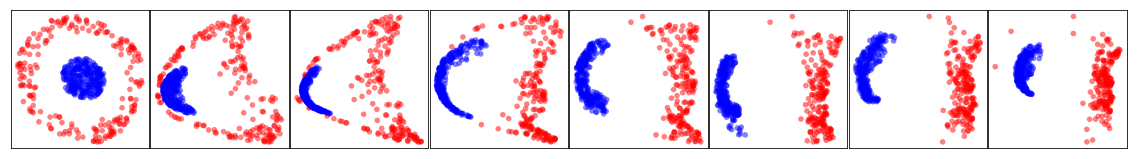

In [17]:
multi_feature_plt(feature_history[::2], viz_y)

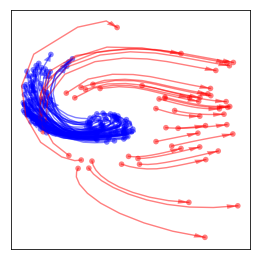

In [18]:
trajectory_plt(model, viz_x[:100], viz_y[:100], timesteps=10, include_arrow=True)

# Augmented ODEs

In [0]:
hidden_dim = 32
EPOCHS = 7

# Add 1 augmented dimension
model = ODENet(hidden_dim, augment_dim=1,
               time_dependent=True, non_linearity='relu')

optimizer = tf.train.AdamOptimizer(0.02)

feature_history = []

# Get features at beginning of training
features, _ = model(viz_x, return_features=True)
feature_history.append(features)

In [20]:
with tf.device('cpu:0'):
  for epoch in range(EPOCHS):
    datagen = iter(dataset)
    
    avg_loss = tf.keras.metrics.Mean()
    
    for batch, (x, y) in enumerate(datagen):
      with tf.GradientTape() as tape:
        x = tf.cast(x, tf.float64)
        y_pred = model(x, training=True)
        
        loss = tf.losses.huber_loss(y, y_pred)
        
      grads = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))
      
      avg_loss(loss)
    
    print("Epoch %d: Loss = %0.6f" % (epoch + 1, avg_loss.result().numpy()))
    
    features, _ = model(viz_x, training=False, return_features=True)
    feature_history.append(features)

Epoch 1: Loss = 0.351707
Epoch 2: Loss = 0.173282
Epoch 3: Loss = 0.081471
Epoch 4: Loss = 0.043622
Epoch 5: Loss = 0.034099
Epoch 6: Loss = 0.024746
Epoch 7: Loss = 0.017572


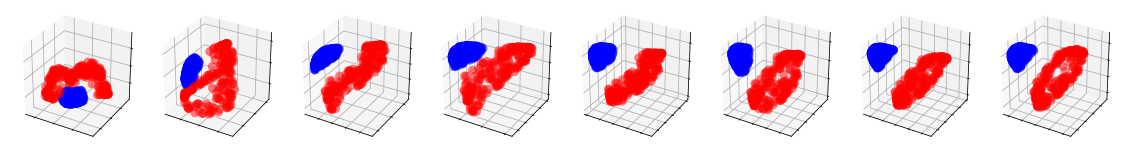

In [21]:
multi_feature_plt(feature_history, viz_y)

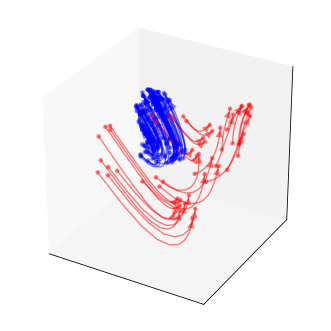

In [22]:
trajectory_plt(model, viz_x[:100], viz_y[:100], timesteps=10, include_arrow=True)